# Plots with confidence interval

In [322]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import json
import numpy as np
from pbo.utils.confidence_interval import confidence_interval


parameters = json.load(open("parameters.json"))

n_states_x = 17
n_states_v = 17
max_bellman_iterations = 15
max_bellman_iterations_validation = max_bellman_iterations + 10
seeds = [10]
n_seeds = len(seeds)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## General case

### Extract data

In [323]:
fqi_q = np.zeros((n_seeds, max_bellman_iterations + 1, n_states_x, n_states_v, 2))
fqi_v = np.zeros((n_seeds, max_bellman_iterations + 1, n_states_x, n_states_v))

for idx_seed, seed in enumerate(seeds):
    fqi_q[idx_seed] = np.load(f"figures/data/FQI/{max_bellman_iterations}_Q_{seed}.npy")
    fqi_v[idx_seed] = np.load(f"figures/data/FQI/{max_bellman_iterations}_V_{seed}.npy")

optimal_q = np.load(f"figures/data/optimal/Q.npy")
optimal_v = np.load(f"figures/data/optimal/V.npy")

pbo_linear_q = np.zeros((n_seeds, max_bellman_iterations_validation + 2, n_states_x, n_states_v, 2))
pbo_linear_v = np.zeros((n_seeds, max_bellman_iterations_validation + 2, n_states_x, n_states_v))

for idx_seed, seed in enumerate(seeds):
    pbo_linear_q[idx_seed] = np.load(f"figures/data/PBO_linear/{max_bellman_iterations}_Q_{seed}.npy")
    pbo_linear_v[idx_seed] = np.load(f"figures/data/PBO_linear/{max_bellman_iterations}_V_{seed}.npy")

samples_count = np.load(f"figures/data/samples_count.npy")
samples_count_q_format = np.repeat(samples_count[:, :, None], 2, axis=-1)

### Distances with the optimal Q function

In [324]:
fqi_q_mean = np.sqrt(np.mean(np.square(fqi_q - optimal_q) * (samples_count_q_format > 0), axis=(2, 3, 4))).mean(axis=0)
fqi_q_std = np.sqrt(np.mean(np.square(fqi_q - optimal_q) * (samples_count_q_format > 0), axis=(2, 3, 4))).std(axis=0)
fqi_q_confidence_interval = confidence_interval(fqi_q_mean, fqi_q_std, n_seeds)

pbo_linear_q_mean = np.sqrt(np.mean(np.square(pbo_linear_q - optimal_q) * (samples_count_q_format > 0), axis=(2, 3, 4))).mean(axis=0)
pbo_linear_q_std = np.sqrt(np.mean(np.square(pbo_linear_q - optimal_q) * (samples_count_q_format > 0), axis=(2, 3, 4))).std(axis=0)
pbo_linear_q_confidence_interval = confidence_interval(pbo_linear_q_mean, pbo_linear_q_std, n_seeds)

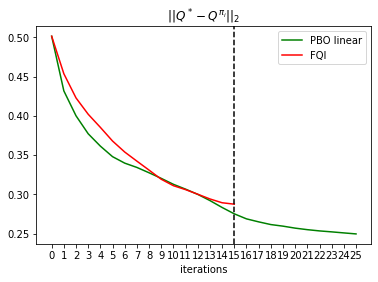

In [325]:
import matplotlib.pyplot as plt 

iterations = range(max_bellman_iterations + 1)
iterations_validation = range(max_bellman_iterations_validation + 1)

plt.plot(iterations_validation, pbo_linear_q_mean[:-1], label="PBO linear", color="green")
plt.fill_between(iterations_validation, pbo_linear_q_confidence_interval[0, :-1], pbo_linear_q_confidence_interval[1, :-1], color="green", alpha=0.3)

# plt.hlines(pbo_linear_q_mean[-1], 0, max_bellman_iterations_validation, color="green", linestyle="--", label="PBO linear fixed point")
# plt.fill_between(iterations_validation, pbo_linear_q_confidence_interval[0, -1], pbo_linear_q_confidence_interval[1, -1], color="green", alpha=0.3)

plt.plot(iterations, fqi_q_mean, label="FQI", color="red")
plt.fill_between(iterations, fqi_q_confidence_interval[0], fqi_q_confidence_interval[1], color="red", alpha=0.3)


plt.axvline(max_bellman_iterations, color="black", linestyle="--")
plt.xticks(iterations_validation)
plt.xlabel("iterations")
plt.title(r"$|| Q^* - Q^{\pi_i} ||_2$")
plt.legend()
_ = plt.savefig(f"figures/distance_to_optimal_Q_{max_bellman_iterations}.jpg", bbox_inches='tight')

### Visualization of the last policies

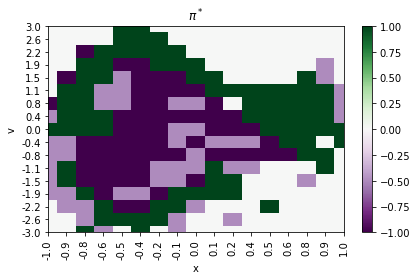

In [326]:
from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh

max_pos = 1.0
max_velocity = 3.0

states_x = np.linspace(-max_pos, max_pos, n_states_x)
states_v = np.linspace(-max_velocity, max_velocity, n_states_v)

q_visu_mesh = TwoDimesionsMesh(states_x, states_v, sleeping_time=0, axis_equal=False, zero_centered=True)

optimal_q_weighted_average = (2 * ((optimal_q[:, :, 1] > optimal_q[:, :, 0])).astype(float) - 1) + (optimal_q[:, :, 1] == optimal_q[:, :, 0]).astype(float) / 2
optimal_q_weighted_average *= (samples_count > 0)

q_visu_mesh.set_values(optimal_q_weighted_average)
q_visu_mesh.show(r"$\pi^*$", xlabel="x", ylabel="v", plot=False)
_ = plt.savefig(f"figures/optimal_pi.jpg", bbox_inches='tight')

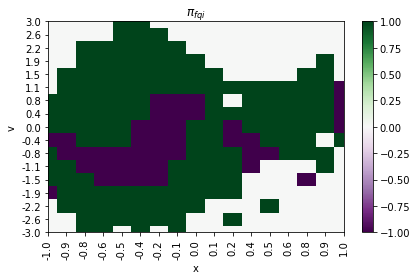

In [327]:
fqi_left_q = fqi_q[:, -1, :, :, 0]
fqi_right_q = fqi_q[:, -1, :, :, 1]
fqi_q_weighted_average = (2 * ((fqi_right_q > fqi_left_q).mean(axis=0)).astype(float) - 1) + (fqi_right_q == fqi_left_q).mean(axis=0) / 2
fqi_q_weighted_average *= (samples_count > 0)

q_visu_mesh.set_values(fqi_q_weighted_average)
q_visu_mesh.show(r"$\pi_{fqi}$", xlabel="x", ylabel="v", plot=False)
_ = plt.savefig(f"figures/fqi_pi_{max_bellman_iterations}.jpg", bbox_inches='tight')

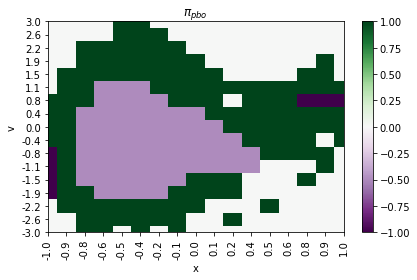

In [328]:
pbo_linear_left_q = pbo_linear_q[:, max_bellman_iterations, :, :, 0]
pbo_linear_right_q = pbo_linear_q[:, max_bellman_iterations, :, :, 1]
pbo_linear_q_weighted_average = (2 * ((pbo_linear_right_q > pbo_linear_left_q).mean(axis=0)).astype(float) - 1) + (pbo_linear_right_q == pbo_linear_left_q).mean(axis=0) / 2
pbo_linear_q_weighted_average *= (samples_count > 0)

q_visu_mesh.set_values(pbo_linear_q_weighted_average)
q_visu_mesh.show(r"$\pi_{pbo}$", xlabel="x", ylabel="v", plot=False)
_ = plt.savefig(f"figures/PBO_linear_pi_{max_bellman_iterations}.jpg", bbox_inches='tight')

### Distance to optimal value function

In [329]:
fqi_v_mean = np.sqrt(np.mean(np.square(fqi_v - optimal_v) * (samples_count > 0), axis=(2, 3))).mean(axis=0)
fqi_v_std = np.sqrt(np.mean(np.square(fqi_v - optimal_v) * (samples_count > 0), axis=(2, 3))).std(axis=0)
fqi_v_confidence_interval = confidence_interval(fqi_v_mean, fqi_v_std, n_seeds)

pbo_linear_v_mean = np.sqrt(np.mean(np.square(pbo_linear_v - optimal_v) * (samples_count > 0), axis=(2, 3))).mean(axis=0)
pbo_linear_v_std = np.sqrt(np.mean(np.square(pbo_linear_v - optimal_v) * (samples_count > 0), axis=(2, 3))).std(axis=0)
pbo_linear_v_confidence_interval = confidence_interval(pbo_linear_v_mean, pbo_linear_v_std, n_seeds)

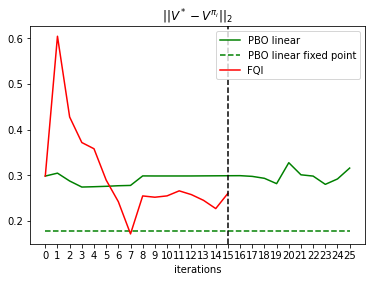

In [330]:
import matplotlib.pyplot as plt 

iterations = range(max_bellman_iterations + 1)
iterations_validation = range(max_bellman_iterations_validation + 1)

plt.plot(iterations_validation, pbo_linear_v_mean[:-1], label="PBO linear", color="green")
plt.fill_between(iterations_validation, pbo_linear_v_confidence_interval[0, :-1], pbo_linear_v_confidence_interval[1, :-1], color="green", alpha=0.3)

plt.hlines(pbo_linear_v_mean[-1], 0, max_bellman_iterations_validation, color="green", linestyle="--", label="PBO linear fixed point")
# plt.fill_between(iterations_validation, pbo_linear_v_confidence_interval[0, -1], pbo_linear_v_confidence_interval[1, -1], color="green", alpha=0.3)

plt.plot(iterations, fqi_v_mean, label="FQI", color="red")
plt.fill_between(iterations, fqi_v_confidence_interval[0], fqi_v_confidence_interval[1], color="red", alpha=0.3)


plt.axvline(max_bellman_iterations, color="black", linestyle="--")
plt.xticks(iterations_validation)
plt.xlabel("iterations")
plt.title(r"$|| V^* - V^{\pi_i} ||_2$")
plt.legend()
_ = plt.savefig(f"figures/distance_to_optimal_V_{max_bellman_iterations}.jpg", bbox_inches='tight')

### Value functions

In [331]:
fqi_v_mean_performance = (fqi_v * (samples_count > 0)).mean(axis=(0, 2, 3))
fqi_v_std_performance = (fqi_v * (samples_count > 0)).std(axis=(0, 2, 3))
fqi_v_confidence_interval_performance = confidence_interval(fqi_v_mean_performance, fqi_v_std_performance, n_seeds)

pbo_linear_v_mean_performance = (pbo_linear_v * (samples_count > 0)).mean(axis=(0, 2, 3))
pbo_linear_v_std_performance = (pbo_linear_v * (samples_count > 0)).std(axis=(0, 2, 3))
pbo_linear_v_confidence_interval_performance = confidence_interval(pbo_linear_v_mean_performance, pbo_linear_v_std_performance, n_seeds)

optimal_v_performance = (optimal_v * (samples_count > 0)).mean()

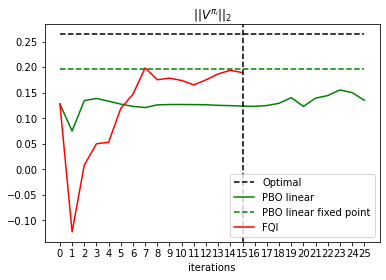

In [332]:
import matplotlib.pyplot as plt 

iterations = range(max_bellman_iterations + 1)
iterations_validation = range(max_bellman_iterations_validation + 1)

plt.hlines(optimal_v_performance, 0, max_bellman_iterations_validation, color="black", linestyle="--", label="Optimal")

plt.plot(iterations_validation, pbo_linear_v_mean_performance[:-1], label="PBO linear", color="green")
plt.fill_between(iterations_validation, pbo_linear_v_confidence_interval_performance[0, :-1], pbo_linear_v_confidence_interval_performance[1, :-1], color="green", alpha=0.3)

plt.hlines(pbo_linear_v_mean_performance[-1], 0, max_bellman_iterations_validation, color="green", linestyle="--", label="PBO linear fixed point")
# plt.fill_between(iterations_validation, pbo_linear_v_confidence_interval[0, -1], pbo_linear_v_confidence_interval[1, -1], color="green", alpha=0.3)

plt.plot(iterations, fqi_v_mean_performance, label="FQI", color="red")
plt.fill_between(iterations, fqi_v_confidence_interval_performance[0], fqi_v_confidence_interval_performance[1], color="red", alpha=0.3)

plt.axvline(max_bellman_iterations, color="black", linestyle="--")
plt.xticks(iterations_validation)
plt.xlabel("iterations")
plt.title(r"$|| V^{\pi_i} ||_2$")
plt.legend()
_ = plt.savefig(f"figures/V_{max_bellman_iterations}.jpg", bbox_inches='tight')

### Visualization of the last value functions

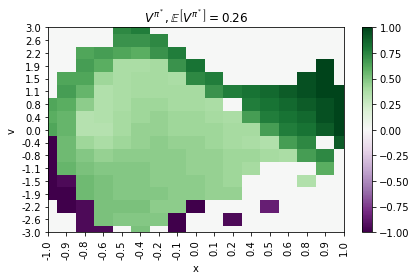

In [333]:
from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh

max_pos = 1.0
max_velocity = 3.0

states_x = np.linspace(-max_pos, max_pos, n_states_x)
states_v = np.linspace(-max_velocity, max_velocity, n_states_v)

q_visu_mesh = TwoDimesionsMesh(states_x, states_v, sleeping_time=0, axis_equal=False, zero_centered=True)

optimal_v_weighted_average = optimal_v * (samples_count > 0)

q_visu_mesh.set_values(optimal_v_weighted_average)
q_visu_mesh.show(r"$V^{\pi^*}, \mathbb{E}\left[ V^{\pi^*} \right] =$" + str(np.round(np.mean(optimal_v_weighted_average), 2)), xlabel="x", ylabel="v", plot=False)
_ = plt.savefig(f"figures/optimal_V_{max_bellman_iterations}.jpg", bbox_inches='tight')

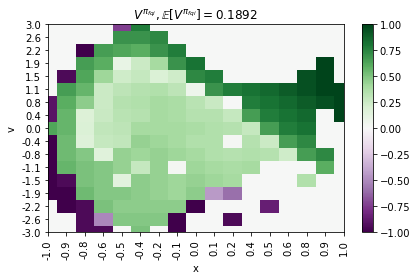

In [334]:
fqi_v_weighted_average = fqi_v[:, -1].mean(axis=0) * (samples_count > 0)

q_visu_mesh.set_values(fqi_v_weighted_average)
q_visu_mesh.show(r"$V^{\pi_{fqi}}, \mathbb{E}\left[ V^{\pi_{fqi}} \right] =$" + f"{np.round(np.mean(fqi_v_weighted_average), 4)}", xlabel="x", ylabel="v", plot=False)
_ = plt.savefig(f"figures/fqi_V_{max_bellman_iterations}.jpg", bbox_inches='tight')

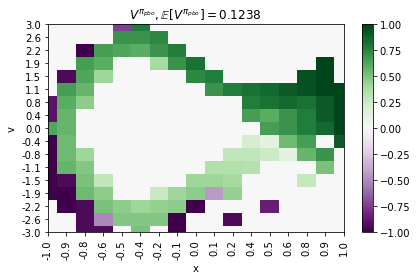

In [337]:
pbo_linear_v_weighted_average = pbo_linear_v[:, max_bellman_iterations].mean(axis=0) * (samples_count > 0)

q_visu_mesh.set_values(pbo_linear_v_weighted_average)
q_visu_mesh.show(r"$V^{\pi_{pbo}}, \mathbb{E}\left[ V^{\pi_{pbo}} \right] =$" + str(np.round(np.mean(pbo_linear_v_weighted_average), 4)), xlabel="x", ylabel="v", plot=False)
_ = plt.savefig(f"figures/PBO_linear_V_{max_bellman_iterations}.jpg", bbox_inches='tight')